# Weather prediction dataset - regression task: tomorrow sunshine hours 
- using full dataset
- using BatchNormalization & Dropout & Early Stopping
- using Monte-Carlo Dropout

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, "dataset")
filename_data = os.path.join(path_data, "weather_prediction_dataset.csv")

In [3]:
data = pd.read_csv(filename_data)
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [4]:
data.shape

(3654, 165)

# Split data into data (X) and labels (y)
We here want to predict the sunshine hours for a particular place (say BASEL which is about in the center of all 18 locations). 

In [5]:
# data
X_data = data.loc[:(data.shape[0]-2)].drop(columns=['DATE', 'MONTH'])

# labels (sunshine hours the next day)
y_data = data.loc[1:]["BASEL_sunshine"] #["BASEL_temp_max"]#["BASEL_global_radiation"]

X_data.shape, y_data.shape

((3653, 163), (3653,))

In [6]:
X_data.head()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BUDAPEST_cloud_cover,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,3,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,8,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,6,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5,8,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6,5,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [7]:
X_data.describe()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BUDAPEST_cloud_cover,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,...,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,5.417739,0.745056,1.017882,1.330723,0.234760,4.662469,11.025021,6.991103,15.539721,4.890227,...,5.108021,11.475691,3.677334,0.781851,1.016643,1.370131,0.186151,12.209006,7.862880,16.555817
std,2.325423,0.107759,0.007956,0.935247,0.536314,4.330018,7.414550,6.653203,8.720706,2.386698,...,7.248085,8.946221,1.520067,0.115581,0.018886,0.926365,0.422198,6.465138,5.691272,7.712116
min,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,-5.700000,0.000000,...,-19.700000,-14.500000,0.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,8.700000,3.000000,...,0.000000,4.100000,2.600000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,15.800000,5.000000,...,5.000000,11.000000,3.400000,0.800000,1.017300,1.240000,0.000000,12.300000,8.300000,16.600000
75%,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,22.300000,7.000000,...,11.200000,19.000000,4.600000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,38.600000,8.000000,...,21.200000,32.900000,10.800000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


<AxesSubplot:>

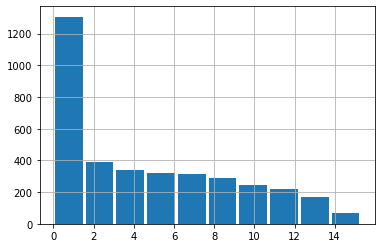

In [8]:
y_data.hist(rwidth=0.9)

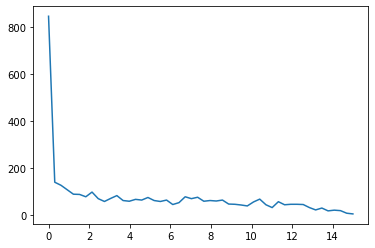

In [9]:
a, b = np.histogram(y_data, 50)
plt.plot(b[:-1], a)

## Create fitting function for distribution

In [12]:
from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a * np.exp(-b * x) + c * x + d

In [13]:
popt, pcov = curve_fit(func, b[:-1], a, p0=[800, 10, -5, 10])

In [14]:
popt

array([751.94850332,   8.78315937,  -4.93143241,  93.89400723])

In [15]:
func(0.01, *popt)

782.5656887695328

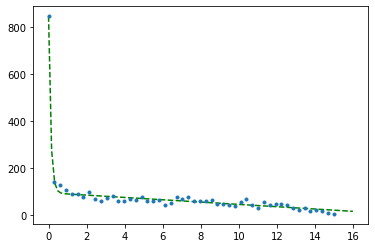

In [16]:
xint = np.linspace(0,16,100)

plt.plot(xint, func(xint, *popt), 'g--')
plt.plot(b[:-1], a, ".")

In [17]:
xint = np.linspace(0,16,100)
from scipy.interpolate import interp1d
f = interp1d(b[:-1], a)

846


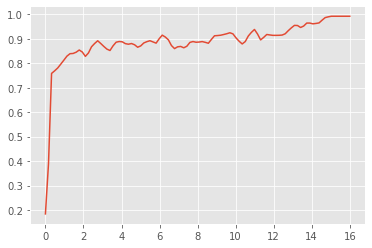

In [52]:
a, b = np.histogram(y_data, 50)
#plt.plot(b[:-1], a)

maxvalue = np.max(a)
print(maxvalue)
xint = np.linspace(0,16,100)
yint = np.interp(xint, b[:-1], a)
plt.plot(xint, np.exp(-0.002*yint))

In [27]:
a, b, c, d = (751.94850332,   8.78315937,  -4.93143241,  93.89400723)
y_true = tf.constant([2, 10, 12.2, 0.])

tf.multiply(a, tf.exp(-b * y_true))

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([1.766985e-05, 0.000000e+00, 0.000000e+00, 7.519485e+02],
      dtype=float32)>

In [53]:
import tensorflow as tf

def custom_loss_function(y_true, y_pred):
    a, b, c, d = (751.94850332,   8.78315937,  -4.93143241,  93.89400723)
    fitresults = tf.multiply(a, tf.exp(-b * y_true)) + tf.multiply(c, y_true) + d
    squared_difference = tf.exp(-0.002 * fitresults) * tf.square(y_true - y_pred)#tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

y_true = tf.constant([2, 10, 12.2, 0.])
y_pred = tf.constant([6.5, 14., 15., 6])
cl = custom_loss_function(np.array(y_true),np.array(y_pred))
cl.numpy()

11.428154

# Split data into training, validation, and test set

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (2557), validation (548) and test set (548).


In [31]:
# this also shuffled the data!
y_train[:10]

746     0.0
3188    2.8
1982    2.0
3396    6.0
2683    0.2
848     3.3
3328    0.7
1255    8.2
3618    0.1
3082    9.2
Name: BASEL_sunshine, dtype: float64

In [32]:
y_train.max(), y_train.min()

(15.3, 0.0)

# Build neural network

In [33]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [34]:
X_train.shape, y_train.shape

((2557, 163), (2557,))

## Measure model uncertainty using Monte-Carlo Dropout
- how to evaluate the model prediction uncertainty

In [54]:
from tensorflow.keras.layers import Dropout

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = BatchNormalization()(layers_input)
    layers_dense = Dense(100, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = Dense(50, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = Dense(10, 'relu')(layers_dense)
    
    # Output layer
    layers_output = Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss=custom_loss_function, #'mse',
              optimizer=Adam(1e-4), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 163)               652       
_________________________________________________________________
dense_12 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)   

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=30,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
80/80 - 2s - loss: 31.2630 - root_mean_squared_error: 5.8471 - val_loss: 20.6024 - val_root_mean_squared_error: 4.8013
Epoch 2/1000
80/80 - 0s - loss: 20.6036 - root_mean_squared_error: 4.7924 - val_loss: 15.4433 - val_root_mean_squared_error: 4.2491
Epoch 3/1000
80/80 - 0s - loss: 14.7351 - root_mean_squared_error: 4.1853 - val_loss: 13.2183 - val_root_mean_squared_error: 4.0253
Epoch 4/1000
80/80 - 0s - loss: 12.9900 - root_mean_squared_error: 4.0484 - val_loss: 11.4675 - val_root_mean_squared_error: 3.8541
Epoch 5/1000
80/80 - 0s - loss: 12.0489 - root_mean_squared_error: 3.9337 - val_loss: 11.3452 - val_root_mean_squared_error: 3.8522
Epoch 6/1000
80/80 - 0s - loss: 10.8804 - root_mean_squared_error: 3.7719 - val_loss: 10.2101 - val_root_mean_squared_error: 3.6745
Epoch 7/1000
80/80 - 0s - loss: 10.5016 - root_mean_squared_error: 3.7289 - val_loss: 10.0270 - val_root_mean_squared_error: 3.6928
Epoch 8/1000
80/80 - 0s - loss: 10.1363 - root_mean_squared_error: 3.6754 - 

Epoch 64/1000
80/80 - 0s - loss: 6.9257 - root_mean_squared_error: 3.1050 - val_loss: 7.3393 - val_root_mean_squared_error: 3.2065
Epoch 65/1000
80/80 - 0s - loss: 7.0997 - root_mean_squared_error: 3.1253 - val_loss: 7.7492 - val_root_mean_squared_error: 3.2585
Epoch 66/1000
80/80 - 0s - loss: 6.9907 - root_mean_squared_error: 3.1233 - val_loss: 7.3889 - val_root_mean_squared_error: 3.1814
Epoch 67/1000
80/80 - 0s - loss: 6.8646 - root_mean_squared_error: 3.0920 - val_loss: 7.5896 - val_root_mean_squared_error: 3.2510
Epoch 68/1000
80/80 - 0s - loss: 7.1323 - root_mean_squared_error: 3.1496 - val_loss: 7.2678 - val_root_mean_squared_error: 3.1833
Epoch 69/1000
80/80 - 0s - loss: 6.9943 - root_mean_squared_error: 3.1110 - val_loss: 7.2828 - val_root_mean_squared_error: 3.1671
Epoch 70/1000
80/80 - 0s - loss: 6.8694 - root_mean_squared_error: 3.0951 - val_loss: 7.4453 - val_root_mean_squared_error: 3.1806
Epoch 71/1000
80/80 - 0s - loss: 6.9183 - root_mean_squared_error: 3.0892 - val_los

Text(0, 0.5, 'RMSE')

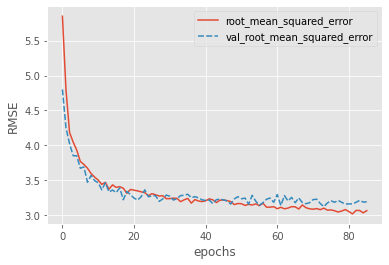

In [56]:
import seaborn as sns

history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'true sunshine hours')

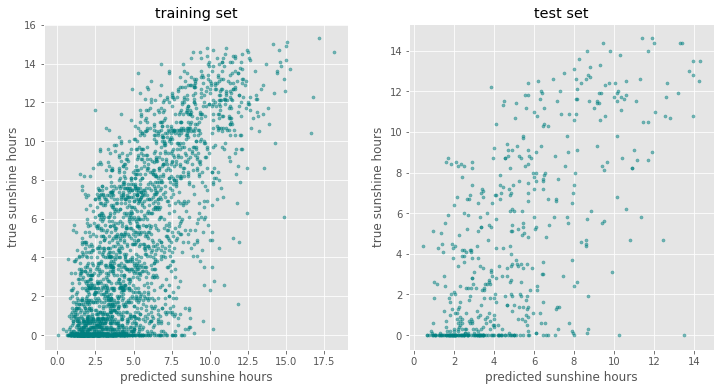

In [57]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_3_dropout.png", dpi=200)

In [58]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 2.,  1.,  5.,  2., 20., 16., 22., 17.,  6.,  9.]),
 array([2.04538655, 2.38616536, 2.72694416, 3.06772296, 3.40850177,
        3.74928057, 4.09005938, 4.43083818, 4.77161698, 5.11239579,
        5.45317459]),
 <BarContainer object of 10 artists>)

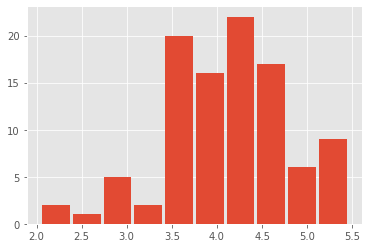

In [59]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

In [60]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [61]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.22832860976342412, 1.8056329286007957)

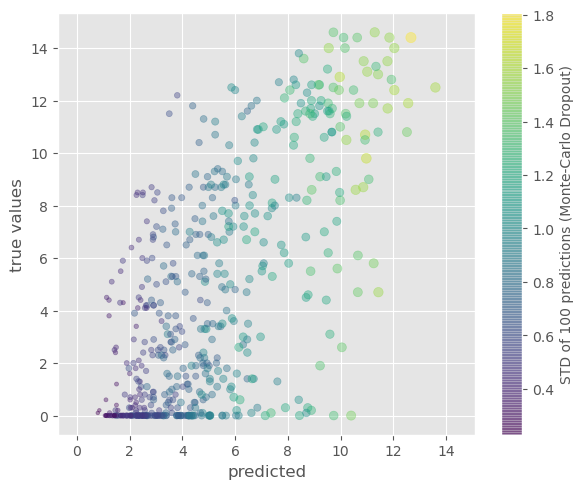

In [62]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=30*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.4)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout.png", dpi=300)

## Same but now predicting global radiation

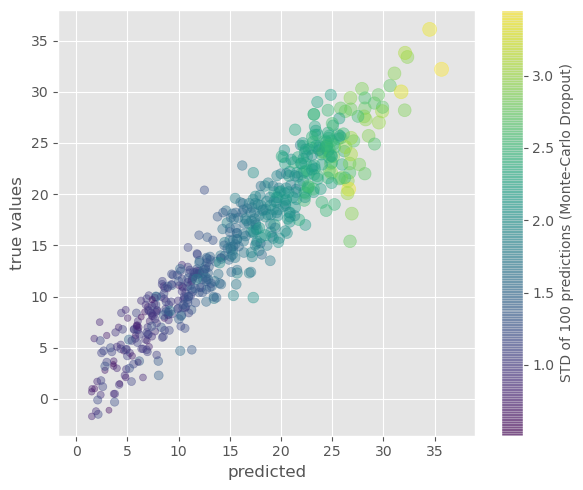

In [90]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=30*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.4)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout.png", dpi=300)

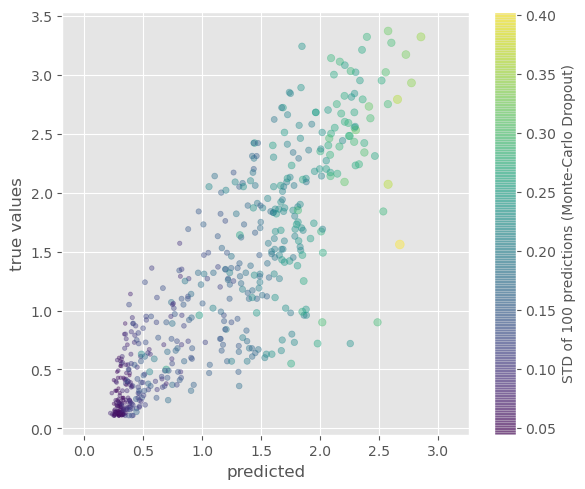

In [68]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=100*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.4)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout.png", dpi=300)

Text(0, 0.5, 'true values')

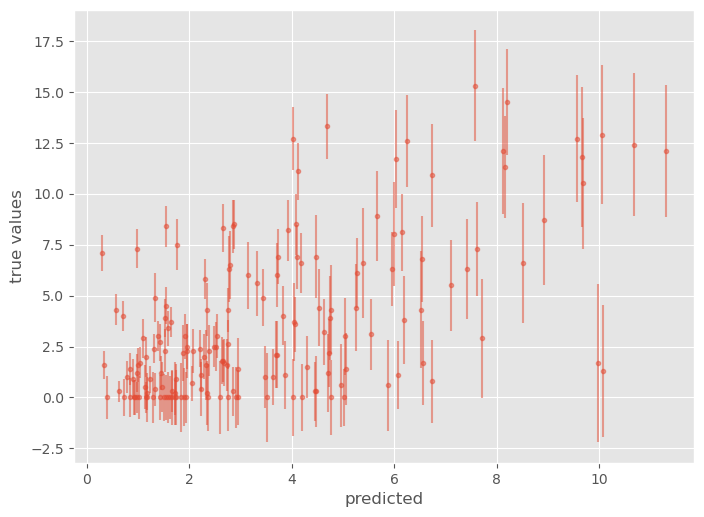

In [157]:
plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(y_test_predicted_mean, y_test, yerr=2*y_test_predicted_std, marker=".", ls="", alpha=0.5)
plt.xlabel("predicted")
plt.ylabel("true values")

# Consider problem of unbalanced data

(array([252.,  78.,  57.,  50.,  62.,  44.,  45.,  43.,  22.,  23.,  21.,
         22.,  23.,   7.,  13.,   5.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

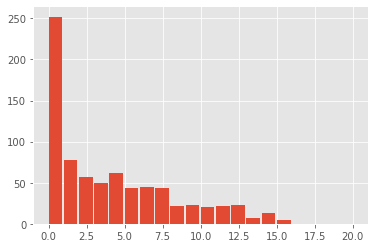

In [58]:
plt.hist(y_train, np.linspace(0,20,21), width=0.9)

In [68]:
np.where(y_train < 1)[0].shape

(252,)

In [84]:
undersampling_remove = np.random.choice(np.where(y_train < 1)[0], 150, replace=False)
keep_idx = np.asarray([i for i in range(y_train.shape[0]) if i not in undersampling_remove])

X_train_undersampling = X_train.values[keep_idx,:]
y_train_undersampling = y_train.values[keep_idx]

(array([102.,  78.,  57.,  50.,  62.,  44.,  45.,  43.,  22.,  23.,  21.,
         22.,  23.,   7.,  13.,   5.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

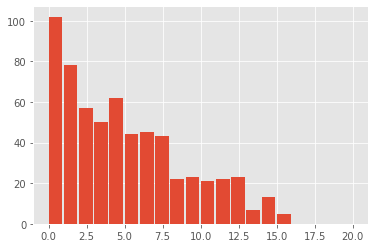

In [85]:
plt.hist(y_train_undersampling, np.linspace(0,20,21), width=0.9)

In [104]:
from tensorflow.keras.layers import Dropout

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = BatchNormalization()(layers_input)
    layers_dense = Dense(100, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense)
    layers_dense = Dense(50, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense)
    layers_dense = Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=Adam(1e-4), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 163)               652       
_________________________________________________________________
dense_39 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 10)   

In [105]:
earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train_undersampling, y_train_undersampling,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
13/13 - 2s - loss: 34.2113 - root_mean_squared_error: 5.8490 - val_loss: 13.8586 - val_root_mean_squared_error: 3.7227
Epoch 2/1000
13/13 - 0s - loss: 31.3042 - root_mean_squared_error: 5.5950 - val_loss: 13.0016 - val_root_mean_squared_error: 3.6058
Epoch 3/1000
13/13 - 0s - loss: 28.4667 - root_mean_squared_error: 5.3354 - val_loss: 12.8447 - val_root_mean_squared_error: 3.5840
Epoch 4/1000
13/13 - 0s - loss: 25.3701 - root_mean_squared_error: 5.0369 - val_loss: 12.7878 - val_root_mean_squared_error: 3.5760
Epoch 5/1000
13/13 - 0s - loss: 23.4982 - root_mean_squared_error: 4.8475 - val_loss: 12.8109 - val_root_mean_squared_error: 3.5792
Epoch 6/1000
13/13 - 0s - loss: 21.0539 - root_mean_squared_error: 4.5885 - val_loss: 12.8842 - val_root_mean_squared_error: 3.5895
Epoch 7/1000
13/13 - 0s - loss: 18.9304 - root_mean_squared_error: 4.3509 - val_loss: 13.0241 - val_root_mean_squared_error: 3.6089
Epoch 8/1000
13/13 - 0s - loss: 17.1082 - root_mean_squared_error: 4.1362 - 

13/13 - 0s - loss: 9.1634 - root_mean_squared_error: 3.0271 - val_loss: 8.8231 - val_root_mean_squared_error: 2.9704
Epoch 64/1000
13/13 - 0s - loss: 9.0772 - root_mean_squared_error: 3.0128 - val_loss: 8.7896 - val_root_mean_squared_error: 2.9647
Epoch 65/1000
13/13 - 0s - loss: 8.8154 - root_mean_squared_error: 2.9691 - val_loss: 8.7919 - val_root_mean_squared_error: 2.9651
Epoch 66/1000
13/13 - 0s - loss: 9.3741 - root_mean_squared_error: 3.0617 - val_loss: 8.7916 - val_root_mean_squared_error: 2.9651
Epoch 67/1000
13/13 - 0s - loss: 9.6183 - root_mean_squared_error: 3.1013 - val_loss: 8.8238 - val_root_mean_squared_error: 2.9705
Epoch 68/1000
13/13 - 0s - loss: 9.1786 - root_mean_squared_error: 3.0296 - val_loss: 8.8158 - val_root_mean_squared_error: 2.9691
Epoch 69/1000
13/13 - 0s - loss: 8.8658 - root_mean_squared_error: 2.9776 - val_loss: 8.8016 - val_root_mean_squared_error: 2.9668
Epoch 70/1000
13/13 - 0s - loss: 8.7467 - root_mean_squared_error: 2.9575 - val_loss: 8.7808 - va

Text(0, 0.5, 'RMSE')

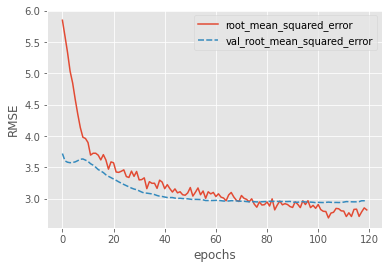

In [106]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
#plt.savefig("03_training_history_5_rmse_dropout_oversampling.png", dpi=200)

In [107]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train_undersampling)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

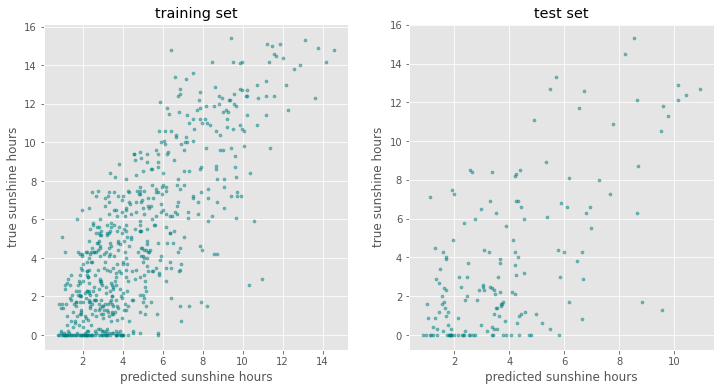

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train_undersampling, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_4_dropout_oversampling.png", dpi=200)

In [63]:
from imblearn.over_sampling import SMOTE #, ADASYN

In [64]:
y_train[:30].values

array([ 0. ,  2.8,  2. ,  6. ,  0.2,  3.3,  0.7,  8.2,  0.1,  9.2,  1.8,
        0. , 10.7,  0.7,  0. ,  5.7,  8.8,  5.3,  0.9,  5.1,  0.7, 13.1,
        6. ,  7.1,  7.7,  7. ,  7.2,  3.6, 12.2,  2.3])

In [65]:
X_train.shape, y_train.shape

((2557, 163), (2557,))

In [67]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE(k_neighbors=2).fit_resample(X_train, y_train.values.astype(int))

In [68]:
X_resampled.shape, X_train.shape

((12208, 163), (2557, 163))

(array([763., 763., 763., 763., 763., 763., 763., 763., 763., 763., 763.,
        763., 763., 763., 763., 763.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

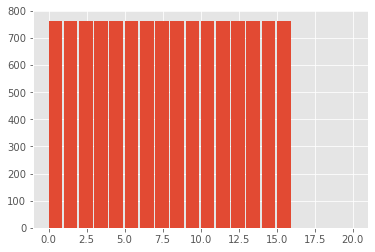

In [69]:
plt.hist(y_resampled, np.linspace(0,20,21), width=0.9)

In [121]:
from tensorflow.keras.layers import Dropout

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = BatchNormalization()(layers_input)
    layers_dense = Dense(100, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.5)(layers_dense, training=True)
    layers_dense = Dense(100, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.5)(layers_dense, training=True)
    layers_dense = Dense(10, 'relu')(layers_dense)
    
    # Output layer
    layers_output = Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse',
              optimizer=Adam(1e-4), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 163)               652       
_________________________________________________________________
dense_55 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 10)   

In [122]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=10,
    verbose=1
    )

history = model.fit(X_resampled, y_resampled,
                    batch_size = 32,
                    epochs = 200,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/200
382/382 - 2s - loss: 36.9506 - root_mean_squared_error: 6.0787 - val_loss: 19.8085 - val_root_mean_squared_error: 4.4507
Epoch 2/200
382/382 - 1s - loss: 16.4310 - root_mean_squared_error: 4.0535 - val_loss: 15.7107 - val_root_mean_squared_error: 3.9637
Epoch 3/200
382/382 - 1s - loss: 14.1674 - root_mean_squared_error: 3.7640 - val_loss: 15.2254 - val_root_mean_squared_error: 3.9020
Epoch 4/200
382/382 - 1s - loss: 13.3409 - root_mean_squared_error: 3.6525 - val_loss: 14.5938 - val_root_mean_squared_error: 3.8202
Epoch 5/200
382/382 - 1s - loss: 12.4504 - root_mean_squared_error: 3.5285 - val_loss: 14.6688 - val_root_mean_squared_error: 3.8300
Epoch 6/200
382/382 - 1s - loss: 12.0195 - root_mean_squared_error: 3.4669 - val_loss: 13.9494 - val_root_mean_squared_error: 3.7349
Epoch 7/200
382/382 - 1s - loss: 11.2266 - root_mean_squared_error: 3.3506 - val_loss: 14.0942 - val_root_mean_squared_error: 3.7542
Epoch 8/200
382/382 - 1s - loss: 11.0644 - root_mean_squared_error: 3

Text(0, 0.5, 'RMSE')

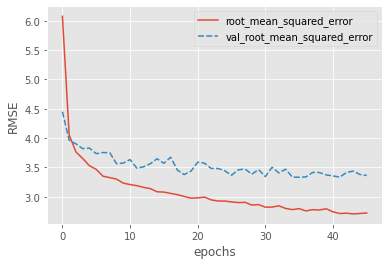

In [123]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
#plt.savefig("03_training_history_5_rmse_dropout_oversampling.png", dpi=200)

In [124]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

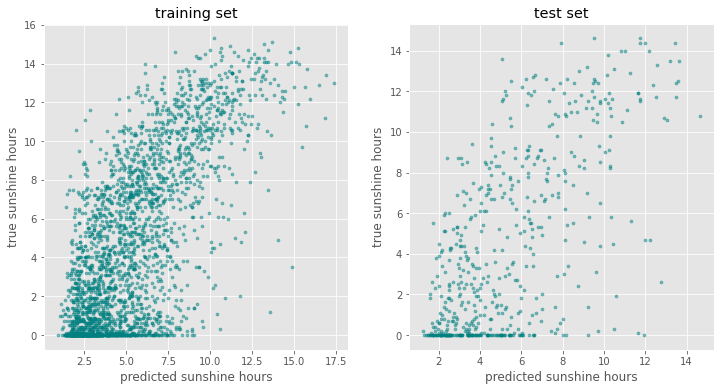

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_4_dropout_oversampling.png", dpi=200)

In [126]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 6., 20., 21., 23., 13., 11.,  4.,  0.,  0.,  2.]),
 array([2.07848811, 2.42996566, 2.78144321, 3.13292077, 3.48439832,
        3.83587587, 4.18735342, 4.53883097, 4.89030852, 5.24178607,
        5.59326363]),
 <BarContainer object of 10 artists>)

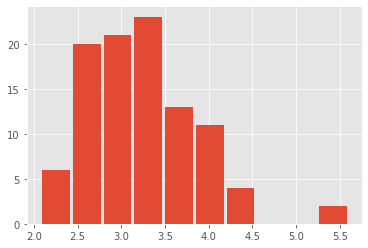

In [127]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

In [128]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [129]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.2679019707273361, 2.480689245060631)

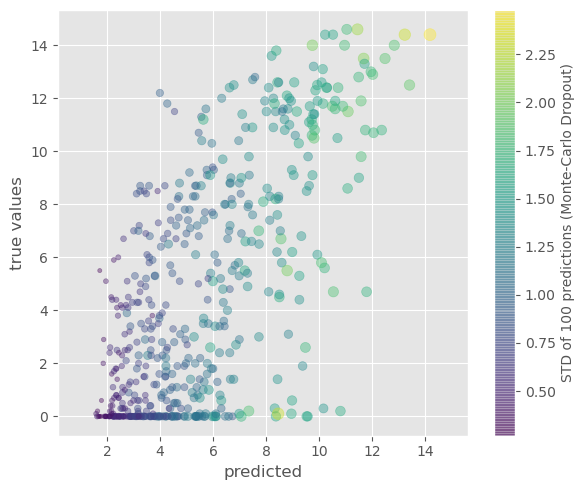

In [130]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=30*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.4)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout.png", dpi=300)